In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import sys
sys.path.append('/home/548/cd3022/aus-historical-solar-droughts/code/python/scripts')
import utils_V2

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
drought_counts = xr.DataArray(np.zeros([103, 1155, 913]), dims=("time", "latitude", "longitude"))
time_coord = [t.time() for t in pd.date_range(start="18:30", periods=103, freq="10min")]
drought_counts = drought_counts.assign_coords(time = time_coord)
drought_counts = drought_counts.assign_coords(time=[t.strftime("%H:%M:%S") for t in drought_counts.time.values])

In [3]:
first = '1-1-2020'
days_per_batch = 5
num_batches = 6

first_dt = datetime.strptime(first, "%d-%m-%Y")
dates = []
for x in range(num_batches):
    start_dt = first_dt + relativedelta(days = days_per_batch * x)
    start_date = start_dt.strftime("%d-%m-%Y")
    end_dt = start_dt + relativedelta(days = days_per_batch) - relativedelta(days=1)
    end_date = end_dt.strftime("%d-%m-%Y")
    dates.append((start_date, end_date))
    print(start_date, '      ', end_date)

01-01-2020        05-01-2020
06-01-2020        10-01-2020
11-01-2020        15-01-2020
16-01-2020        20-01-2020
21-01-2020        25-01-2020
26-01-2020        30-01-2020


In [4]:
for start, end in dates:
    data = xr.open_dataarray(f'/g/data/er8/users/cd3022/solar_drought/REZ_tilting/ideal_ratio/drought_heatmap/{start}___{end}___0.1.nc')
    drought_counts += data

In [5]:
data = drought_counts.where(drought_counts != 0, np.nan)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


([<matplotlib.axis.XTick at 0x14644be42530>,
 [Text(0.0, 0, '18:30:00'),
  Text(17.0, 0, '21:20:00'),
  Text(34.0, 0, '00:10:00'),
  Text(51.0, 0, '03:00:00'),
  Text(68.0, 0, '05:50:00'),
  Text(85.0, 0, '08:40:00'),
  Text(102.0, 0, '11:30:00')])

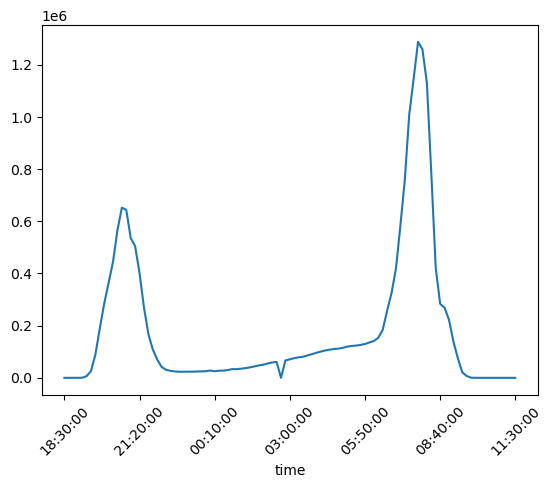

In [7]:
data.sum(dim=["latitude", "longitude"], skipna=True).plot()

time_values = data.time.values
plt.xticks(time_values[::len(time_values)//6], rotation=45)

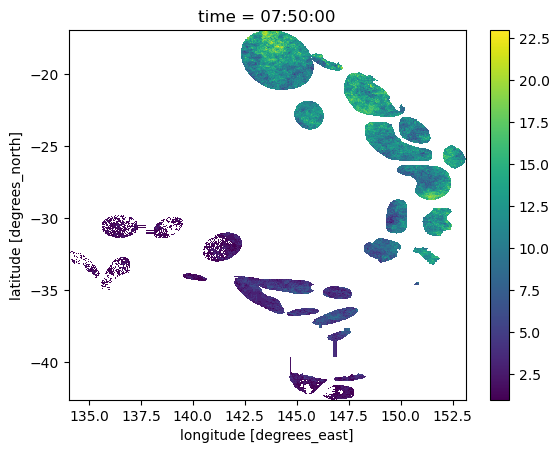

In [18]:
data.isel(time=80).plot()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


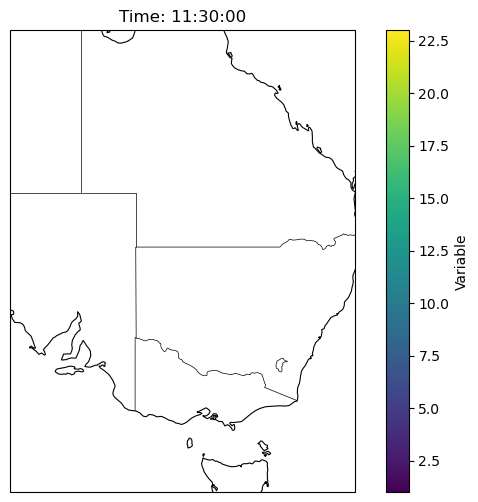

In [19]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = plt.cm.viridis  # Choose a colormap
vmin, vmax = np.nanmin(data), np.nanmax(data)  # Normalize color scale

# Create the initial plot (first frame)
img = ax.imshow(data.isel(time=0), cmap=cmap, vmin=vmin, vmax=vmax,
                extent=[data.longitude.min(), data.longitude.max(), data.latitude.min(), data.latitude.max()],
                origin='lower', transform=ccrs.PlateCarree())
ax.set_title(f"Time: {data.time.values[0]}")  # Set initial title
plt.colorbar(img, ax=ax, label="Variable")

# Add coastlines
ax.coastlines()
# Add Australian state borders
state_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none'
)
ax.add_feature(state_borders, edgecolor='black', linewidth=0.5)

# Function to update the frame
def update(frame):
    img.set_array(data.isel(time=frame))  # Update data
    ax.set_title(f"Time: {data.time.values[frame]}")  # Update title
    return img,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=103, interval=200, blit=False)

# Save as a video (MP4) or GIF
# ani.save("animation.mp4", writer="ffmpeg", dpi=150)  # Save as MP4
ani.save("animation.gif", writer="pillow", dpi=150)  # Save as GIF

# Show animation inline (if using Jupyter Notebook)
plt.show()
plt.close(fig)